# 1-6: SHAP 설명 시스템

## 학습 목표
- XGBoost 모델에 TreeExplainer 적용
- SHAP 시각화 (Summary, Waterfall, Force, Dependence)
- Top K 피처 추출 및 자연어 설명 생성
- API 응답 포맷 구현
- src/explainer 모듈화

## 이 노트북에서 할 것
```
xgb_model.joblib → TreeExplainer → SHAP 값 계산
                                 ↘ 시각화
                                 ↘ Top K 피처
                                 ↘ 자연어 설명
                                 ↘ API 응답 포맷
                                 ↘ src/explainer 모듈
```

In [1]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

# SHAP
import shap
shap.initjs()

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 경로
DATA_PROCESSED = Path('../../data/processed')
MODELS_DIR = Path('../../models')
SRC_DIR = Path('../../src')

# 헬퍼 함수: SHAP 버전 호환성
def get_base_value(explainer):
    """SHAP expected_value를 스칼라로 반환 (버전 호환)"""
    ev = explainer.expected_value
    if hasattr(ev, '__len__'):
        return float(ev[0])
    return float(ev)

print(f"SHAP 버전: {shap.__version__}")
print("패키지 로드 완료!")

SHAP 버전: 0.50.0
패키지 로드 완료!


---

## 섹션 1: 모델 및 데이터 로드

In [2]:
%%time
# XGBoost 모델 로드
xgb_info = joblib.load(MODELS_DIR / 'xgb_model.joblib')
xgb_model = xgb_info['model']
optimal_threshold = xgb_info['optimal_threshold']
test_auc = xgb_info['test_auc']

print("XGBoost 모델 로드 완료!")
print(f"  Test AUC: {test_auc:.4f}")
print(f"  최적 Threshold: {optimal_threshold:.2f}")

XGBoost 모델 로드 완료!
  Test AUC: 0.9114
  최적 Threshold: 0.18
CPU times: total: 156 ms
Wall time: 318 ms


In [3]:
%%time
# 테스트 데이터 로드
test_df = pd.read_csv(DATA_PROCESSED / 'test_features.csv')

# X, y 분리
X_test = test_df.drop('isFraud', axis=1)
y_test = test_df['isFraud']

# 피처 이름
feature_names = X_test.columns.tolist()

print(f"테스트 데이터: {X_test.shape}")
print(f"피처 수: {len(feature_names)}")
print(f"사기 비율: {y_test.mean():.2%}")

테스트 데이터: (118108, 447)
피처 수: 447
사기 비율: 3.44%
CPU times: total: 3.97 s
Wall time: 4.24 s


In [4]:
# 샘플링 (메모리 및 속도)
N_SAMPLES = 1000

# 사기/정상 비율 유지하며 샘플링
np.random.seed(42)
fraud_idx = y_test[y_test == 1].index
normal_idx = y_test[y_test == 0].index

# 사기 50개, 정상 950개 (실제 비율 반영)
n_fraud = min(50, len(fraud_idx))
n_normal = N_SAMPLES - n_fraud

sample_idx = np.concatenate([
    np.random.choice(fraud_idx, n_fraud, replace=False),
    np.random.choice(normal_idx, n_normal, replace=False)
])
np.random.shuffle(sample_idx)

X_sample = X_test.iloc[sample_idx].reset_index(drop=True)
y_sample = y_test.iloc[sample_idx].reset_index(drop=True)

print(f"샘플 데이터: {X_sample.shape}")
print(f"사기 비율: {y_sample.mean():.2%}")

샘플 데이터: (1000, 447)
사기 비율: 5.00%


In [5]:
# 체크포인트
assert xgb_model is not None, "모델이 로드되지 않았습니다!"
assert len(feature_names) == 447, f"피처 수가 다릅니다: {len(feature_names)}"
print("✅ 모델 및 데이터 로드 체크 통과!")

✅ 모델 및 데이터 로드 체크 통과!


---

## 섹션 2: TreeExplainer + SHAP 계산

In [6]:
%%time
# TreeExplainer 생성
explainer = shap.TreeExplainer(xgb_model)

print(f"Explainer 타입: {type(explainer).__name__}")
print(f"Expected value (기본값): {get_base_value(explainer):.4f}")

Explainer 타입: TreeExplainer
Expected value (기본값): 0.0000
CPU times: total: 656 ms
Wall time: 278 ms


In [7]:
%%time
# SHAP 값 계산
shap_values = explainer.shap_values(X_sample)

print(f"SHAP values shape: {shap_values.shape}")
print(f"  - 샘플 수: {shap_values.shape[0]}")
print(f"  - 피처 수: {shap_values.shape[1]}")

SHAP values shape: (1000, 447)
  - 샘플 수: 1000
  - 피처 수: 447
CPU times: total: 1.03 s
Wall time: 488 ms


In [8]:
# 체크포인트: SHAP 값 형태
assert shap_values.shape == (N_SAMPLES, 447), f"SHAP 값 shape이 다릅니다: {shap_values.shape}"
assert np.isfinite(shap_values).all(), "SHAP 값에 NaN/Inf가 있습니다!"
print("✅ SHAP 계산 체크 통과!")

✅ SHAP 계산 체크 통과!


In [9]:
# 예측 확률
y_prob = xgb_model.predict_proba(X_sample)[:, 1]

# SHAP 값 합계 검증 (log-odds 기준)
base_value = get_base_value(explainer)
shap_sum = shap_values.sum(axis=1)
reconstructed = base_value + shap_sum

# log-odds → probability 변환하여 비교
reconstructed_prob = 1 / (1 + np.exp(-reconstructed))

# 상관관계 확인 (완전 일치는 아님, 근사)
corr = np.corrcoef(y_prob, reconstructed_prob)[0, 1]
print(f"예측 확률 vs SHAP 재구성 상관관계: {corr:.4f}")

# 샘플 몇 개 비교
print("\n샘플 비교:")
for i in range(5):
    print(f"  샘플 {i}: 예측={y_prob[i]:.4f}, 재구성={reconstructed_prob[i]:.4f}")

예측 확률 vs SHAP 재구성 상관관계: 1.0000

샘플 비교:
  샘플 0: 예측=0.1084, 재구성=0.1084
  샘플 1: 예측=0.0261, 재구성=0.0261
  샘플 2: 예측=0.0686, 재구성=0.0686
  샘플 3: 예측=0.0288, 재구성=0.0288
  샘플 4: 예측=0.2145, 재구성=0.2145


---

## 섹션 3: SHAP 시각화

### 3-1. Summary Plot (전체 중요도)

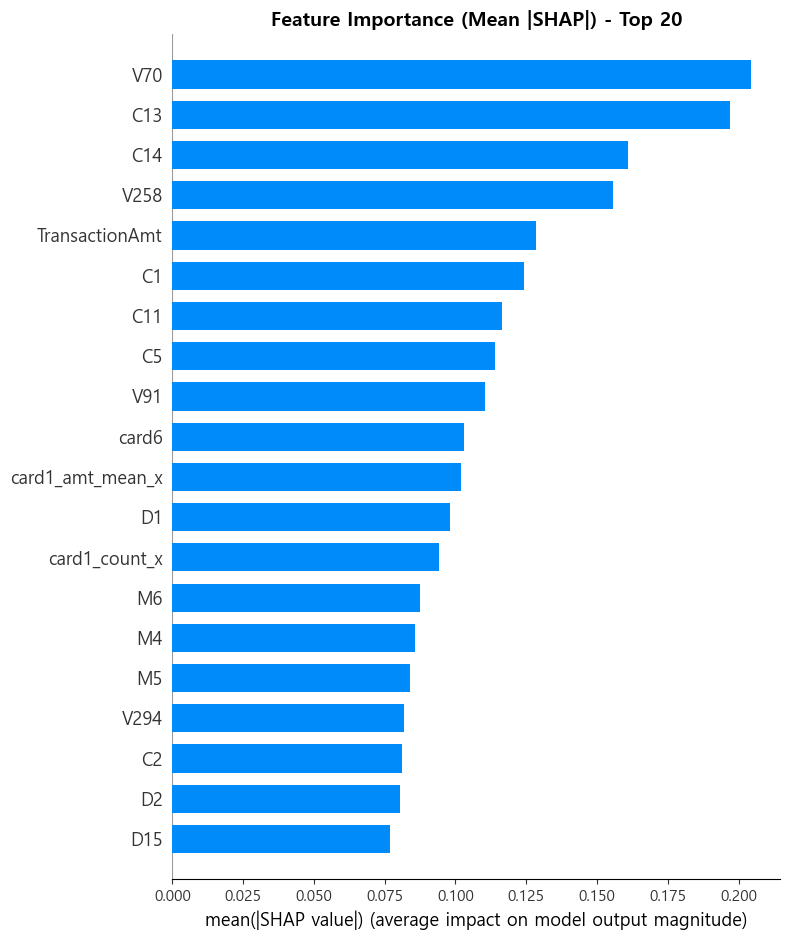


해석:
  - 막대가 길수록 예측에 큰 영향
  - 글로벌 중요도 (전체 데이터 기준)


In [10]:
# Summary Plot - Bar (Top 20)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, plot_type='bar', max_display=20, show=False)
plt.title('Feature Importance (Mean |SHAP|) - Top 20', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n해석:")
print("  - 막대가 길수록 예측에 큰 영향")
print("  - 글로벌 중요도 (전체 데이터 기준)")

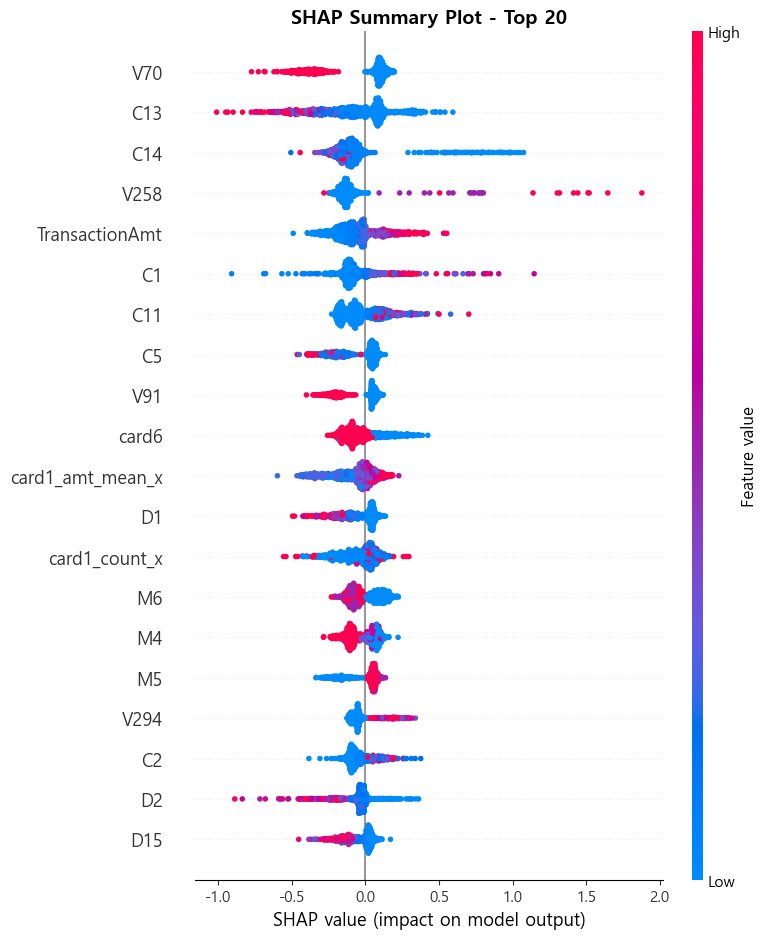


해석:
  - X축: SHAP 값 (양수=사기 위험↑, 음수=사기 위험↓)
  - 색상: 피처 값 (빨강=높음, 파랑=낮음)
  - 점 하나 = 샘플 하나


In [11]:
# Summary Plot - Dot (Top 20)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, max_display=20, show=False)
plt.title('SHAP Summary Plot - Top 20', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n해석:")
print("  - X축: SHAP 값 (양수=사기 위험↑, 음수=사기 위험↓)")
print("  - 색상: 피처 값 (빨강=높음, 파랑=낮음)")
print("  - 점 하나 = 샘플 하나")

### 3-2. Waterfall Plot (개별 예측 분해)

In [12]:
# 사기로 예측된 샘플 찾기
fraud_preds = np.where(y_prob > optimal_threshold)[0]
print(f"사기로 예측된 샘플 수: {len(fraud_preds)}")

if len(fraud_preds) > 0:
    # 첫 번째 사기 예측 샘플
    fraud_idx = fraud_preds[0]
    
    print(f"\n샘플 {fraud_idx} 분석:")
    print(f"  예측 확률: {y_prob[fraud_idx]:.2%}")
    print(f"  실제 라벨: {'사기' if y_sample.iloc[fraud_idx] == 1 else '정상'}")

사기로 예측된 샘플 수: 311

샘플 4 분석:
  예측 확률: 21.45%
  실제 라벨: 정상


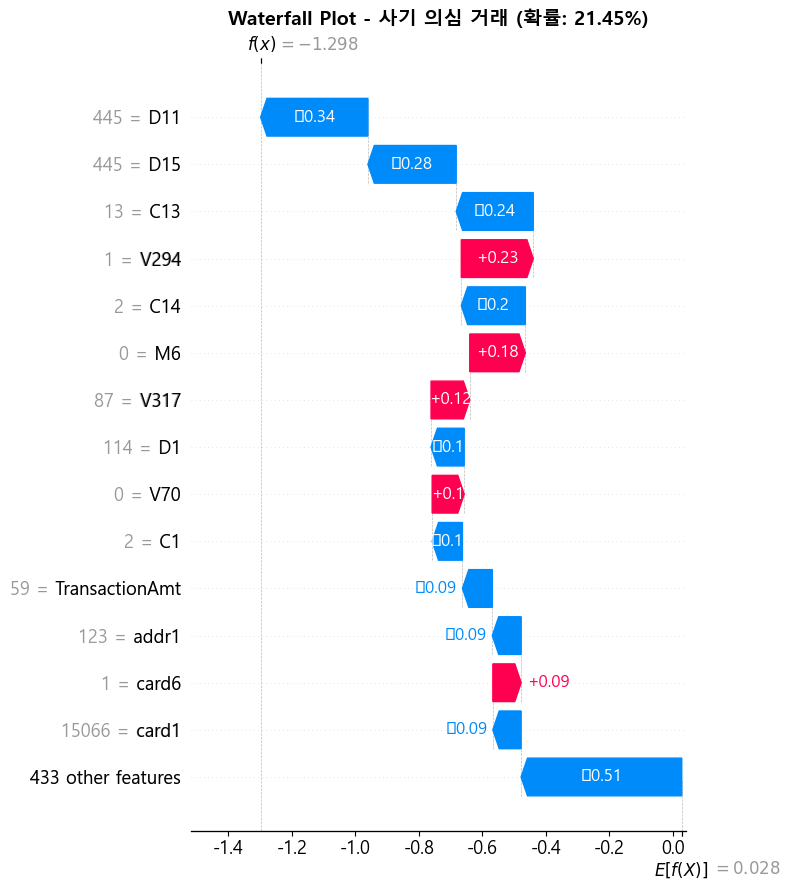


해석:
  - E[f(x)]: 기본값 (평균 예측)
  - 빨간색: 사기 위험 높이는 피처
  - 파란색: 사기 위험 낮추는 피처
  - f(x): 최종 예측값


In [13]:
# Waterfall Plot
if len(fraud_preds) > 0:
    fraud_idx = fraud_preds[0]
    
    # Explanation 객체 생성
    explanation = shap.Explanation(
        values=shap_values[fraud_idx],
        base_values=get_base_value(explainer),
        data=X_sample.iloc[fraud_idx].values,
        feature_names=feature_names
    )
    
    plt.figure(figsize=(12, 8))
    shap.waterfall_plot(explanation, max_display=15, show=False)
    plt.title(f'Waterfall Plot - 사기 의심 거래 (확률: {y_prob[fraud_idx]:.2%})', 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n해석:")
    print("  - E[f(x)]: 기본값 (평균 예측)")
    print("  - 빨간색: 사기 위험 높이는 피처")
    print("  - 파란색: 사기 위험 낮추는 피처")
    print("  - f(x): 최종 예측값")

### 3-3. Force Plot

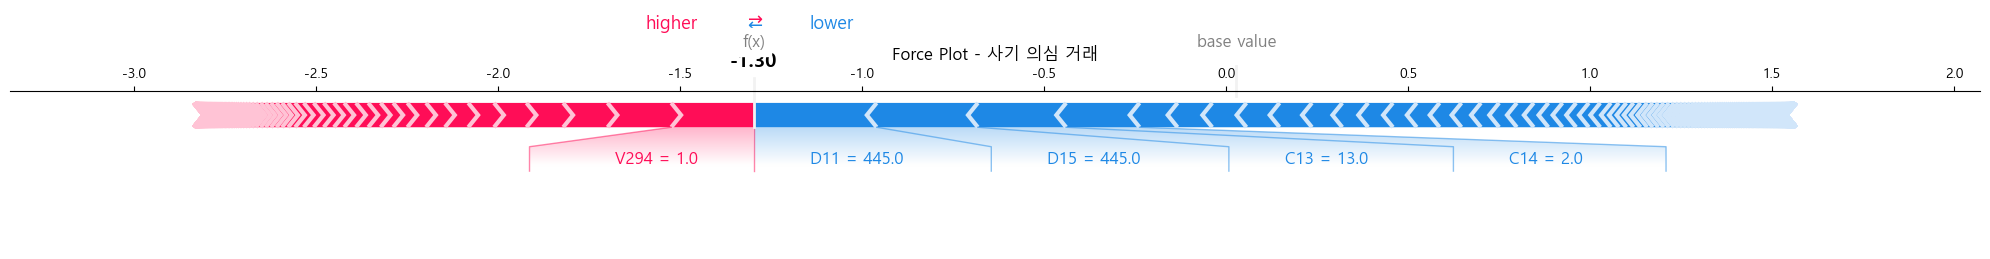


해석:
  - 빨간색: 사기 위험 높이는 피처 (왼쪽으로 밀어냄)
  - 파란색: 사기 위험 낮추는 피처 (오른쪽으로 밀어냄)


In [14]:
# Force Plot (단일 샘플)
if len(fraud_preds) > 0:
    fraud_idx = fraud_preds[0]
    
    shap.force_plot(
        get_base_value(explainer),
        shap_values[fraud_idx],
        X_sample.iloc[fraud_idx],
        feature_names=feature_names,
        matplotlib=True,
        show=False
    )
    plt.title(f'Force Plot - 사기 의심 거래', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    print("\n해석:")
    print("  - 빨간색: 사기 위험 높이는 피처 (왼쪽으로 밀어냄)")
    print("  - 파란색: 사기 위험 낮추는 피처 (오른쪽으로 밀어냄)")

### 3-4. Dependence Plot

In [15]:
# 가장 중요한 피처 Top 5
mean_shap = np.abs(shap_values).mean(axis=0)
top5_idx = np.argsort(mean_shap)[-5:][::-1]
top5_features = [feature_names[i] for i in top5_idx]

print("Top 5 피처:")
for i, (idx, feat) in enumerate(zip(top5_idx, top5_features)):
    print(f"  {i+1}. {feat}: mean |SHAP| = {mean_shap[idx]:.4f}")

Top 5 피처:
  1. V70: mean |SHAP| = 0.2044
  2. C13: mean |SHAP| = 0.1970
  3. C14: mean |SHAP| = 0.1609
  4. V258: mean |SHAP| = 0.1556
  5. TransactionAmt: mean |SHAP| = 0.1286


<Figure size 1000x600 with 0 Axes>

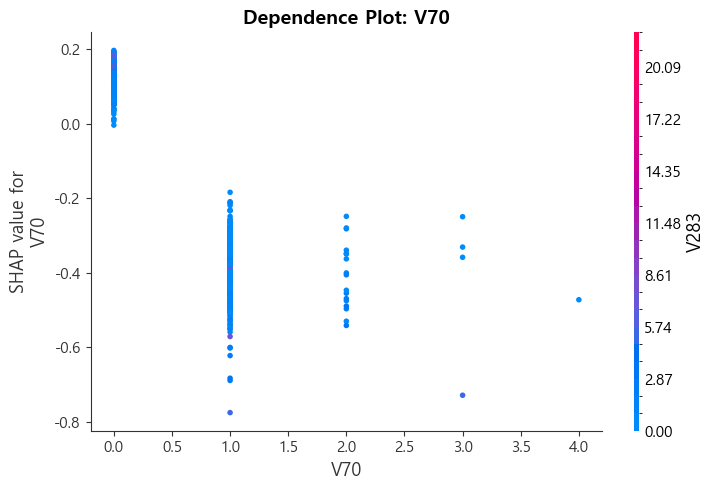


해석 (V70):
  - X축: 피처 값
  - Y축: SHAP 값
  - 색상: 상호작용하는 피처


In [16]:
# Top 1 피처 Dependence Plot
top_feature = top5_features[0]

plt.figure(figsize=(10, 6))
shap.dependence_plot(
    top_feature,
    shap_values,
    X_sample,
    feature_names=feature_names,
    show=False
)
plt.title(f'Dependence Plot: {top_feature}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n해석 ({top_feature}):")
print("  - X축: 피처 값")
print("  - Y축: SHAP 값")
print("  - 색상: 상호작용하는 피처")

In [17]:
# 체크포인트: 시각화
assert len(top5_features) == 5, "Top 5 피처가 추출되지 않았습니다!"
print("✅ SHAP 시각화 체크 통과!")

✅ SHAP 시각화 체크 통과!


---

## 섹션 4: Top K 피처 추출

In [18]:
def get_top_features(shap_values, feature_names, sample_idx, top_k=5):
    """
    개별 샘플의 Top K 기여 피처 추출
    
    Args:
        shap_values: SHAP 값 배열 (n_samples, n_features)
        feature_names: 피처 이름 리스트
        sample_idx: 샘플 인덱스
        top_k: 상위 K개
    
    Returns:
        List[Dict]: Top K 피처 정보
    """
    # 해당 샘플의 SHAP 값
    sample_shap = shap_values[sample_idx]
    
    # 절대값 기준 정렬
    importance = np.abs(sample_shap)
    top_indices = np.argsort(importance)[-top_k:][::-1]
    
    return [
        {
            'feature': feature_names[i],
            'shap_value': float(sample_shap[i]),
            'impact': float(importance[i]),
            'direction': 'increase' if sample_shap[i] > 0 else 'decrease'
        }
        for i in top_indices
    ]

# 테스트
if len(fraud_preds) > 0:
    fraud_idx = fraud_preds[0]
    top_features = get_top_features(shap_values, feature_names, fraud_idx, top_k=5)
    
    print(f"샘플 {fraud_idx}의 Top 5 피처:")
    for i, f in enumerate(top_features):
        sign = '+' if f['direction'] == 'increase' else '-'
        print(f"  {i+1}. {f['feature']}: {sign}{f['impact']:.4f}")

샘플 4의 Top 5 피처:
  1. D11: -0.3378
  2. D15: -0.2780
  3. C13: -0.2426
  4. V294: +0.2267
  5. C14: -0.2017


In [19]:
# 체크포인트: Top K 추출
assert len(top_features) == 5, "Top 5 피처가 추출되지 않았습니다!"
assert all('feature' in f and 'impact' in f for f in top_features), "피처 정보 형식 오류"
print("✅ Top K 추출 체크 통과!")

✅ Top K 추출 체크 통과!


---

## 섹션 5: 자연어 설명 생성

In [33]:
# 주요 피처 한글 매핑
FEATURE_DESC = {
    # 거래 정보
    'TransactionAmt': '거래금액',
    'TransactionAmt_log': '거래금액(로그)',
    'ProductCD': '상품코드',
    
    # 카드 정보
    'card1': '카드번호1',
    'card2': '카드번호2',
    'card3': '카드번호3',
    'card4': '카드종류',
    'card5': '카드등급',
    'card6': '카드유형',
    
    # 주소 정보
    'addr1': '청구지주소',
    'addr2': '배송지주소',
    'dist1': '거리1',
    'dist2': '거리2',
    
    # 이메일 도메인
    'P_emaildomain': '구매자이메일',
    'R_emaildomain': '수령자이메일',
    
    # 시간 피처
    'hour': '거래시간',
    'dayofweek': '요일',
    'day': '일자',
    
    # C 피처 (카운팅)
    'C1': '주소일치횟수',
    'C2': '카드사용횟수',
    
    # D 피처 (시간차)
    'D1': '이전거래간격',
    'D2': '거래시간차',
    'D3': '카드사용간격',
    
    # V 피처 (익명화된 Vesta 피처)
    'V1': 'Vesta특성1',
    'V2': 'Vesta특성2',
    # ... (V 피처는 익명화되어 의미 알 수 없음)
}

def to_natural_language(top_features, max_display=3):
    """
    Top 피처를 자연어 설명으로 변환
    
    Args:
        top_features: get_top_features() 결과
        max_display: 표시할 최대 피처 수
    
    Returns:
        str: 자연어 설명
    """
    lines = ["[사기 판단 근거]"]
    
    for f in top_features[:max_display]:
        feature = f['feature']
        # 한글 이름 또는 원래 이름 사용
        name_kr = FEATURE_DESC.get(feature, feature)
        
        # 방향성 해석
        if f['direction'] == 'increase':
            direction_kr = "사기 위험 증가"
        else:
            direction_kr = "사기 위험 감소"
        
        # 영향도 표시
        impact = f['impact']
        if impact > 1.0:
            strength = "매우 높음"
        elif impact > 0.5:
            strength = "높음"
        elif impact > 0.2:
            strength = "중간"
        else:
            strength = "낮음"
        
        lines.append(f"- {name_kr}: {direction_kr} (영향도 {strength})")
    
    return "\n".join(lines)

# 테스트
if len(fraud_preds) > 0:
    explanation_text = to_natural_language(top_features)
    print(explanation_text)

[사기 판단 근거]
- D11: 사기 위험 감소 (영향도 중간)
- D15: 사기 위험 감소 (영향도 중간)
- C13: 사기 위험 감소 (영향도 중간)


In [34]:
# 체크포인트: 자연어 설명
assert "[사기 판단 근거]" in explanation_text, "자연어 설명 형식 오류"
print("✅ 자연어 설명 체크 통과!")

✅ 자연어 설명 체크 통과!


---

## 섹션 6: API 응답 포맷

In [35]:
def create_explanation_response(sample_idx, shap_values, feature_names, pred_prob, threshold=0.5, top_k=5):
    """
    API 응답용 설명 생성
    
    Args:
        sample_idx: 샘플 인덱스
        shap_values: SHAP 값 배열
        feature_names: 피처 이름 리스트
        pred_prob: 예측 확률
        threshold: 사기 판단 임계값
        top_k: Top K 피처
    
    Returns:
        Dict: API 응답
    """
    # Top K 피처
    top_features = get_top_features(shap_values, feature_names, sample_idx, top_k)
    
    # 자연어 설명
    explanation_text = to_natural_language(top_features)
    
    return {
        "fraud_probability": float(pred_prob),
        "is_fraud": bool(pred_prob >= threshold),
        "top_factors": [
            {
                "feature": f['feature'],
                "feature_kr": FEATURE_DESC.get(f['feature'], f['feature']),
                "impact": round(f['impact'], 4),
                "direction": f['direction']
            }
            for f in top_features
        ],
        "explanation_text": explanation_text
    }

# 테스트
if len(fraud_preds) > 0:
    fraud_idx = fraud_preds[0]
    response = create_explanation_response(
        fraud_idx, 
        shap_values, 
        feature_names, 
        y_prob[fraud_idx],
        threshold=optimal_threshold
    )
    
    print("API 응답 예시:")
    print(json.dumps(response, indent=2, ensure_ascii=False))

API 응답 예시:
{
  "fraud_probability": 0.21449974179267883,
  "is_fraud": true,
  "top_factors": [
    {
      "feature": "D11",
      "feature_kr": "D11",
      "impact": 0.3378,
      "direction": "decrease"
    },
    {
      "feature": "D15",
      "feature_kr": "D15",
      "impact": 0.278,
      "direction": "decrease"
    },
    {
      "feature": "C13",
      "feature_kr": "C13",
      "impact": 0.2426,
      "direction": "decrease"
    },
    {
      "feature": "V294",
      "feature_kr": "V294",
      "impact": 0.2267,
      "direction": "increase"
    },
    {
      "feature": "C14",
      "feature_kr": "C14",
      "impact": 0.2017,
      "direction": "decrease"
    }
  ],
  "explanation_text": "[사기 판단 근거]\n- D11: 사기 위험 감소 (영향도 중간)\n- D15: 사기 위험 감소 (영향도 중간)\n- C13: 사기 위험 감소 (영향도 중간)"
}


In [36]:
# 체크포인트: JSON 변환
json_str = json.dumps(response)
parsed = json.loads(json_str)
assert 'fraud_probability' in parsed, "API 응답에 fraud_probability가 없습니다!"
assert 'top_factors' in parsed, "API 응답에 top_factors가 없습니다!"
assert len(parsed['top_factors']) == 5, "Top 5 피처가 포함되지 않았습니다!"
print("✅ API 응답 포맷 체크 통과!")

✅ API 응답 포맷 체크 통과!


---

## 섹션 7: src/explainer 모듈 테스트

> **현업 방식**: 모듈 코드는 `src/explainer/shap_explainer.py`에 별도 관리  
> 노트북에서는 임포트 + 테스트만 수행

In [50]:
# 모듈 테스트
import sys
import importlib
sys.path.insert(0, str(SRC_DIR.parent))

# 모듈 직접 리로드 후 임포트 (패키지 캐시 우회)
import src.explainer.shap_explainer as shap_module
importlib.reload(shap_module)
ShapExplainer = shap_module.ShapExplainer

# ShapExplainer 사용
shap_exp = ShapExplainer(xgb_model, feature_names)

# 테스트 샘플
test_sample = X_sample.iloc[:10]
shap_vals = shap_exp.explain(test_sample)

print(f"모듈 테스트 성공!")
print(f"  SHAP values shape: {shap_vals.shape}")

모듈 테스트 성공!
  SHAP values shape: (10, 447)


In [51]:
# 모듈로 API 응답 생성
if len(fraud_preds) > 0:
    # 사기 샘플 찾기
    test_fraud_idx = np.where(xgb_model.predict_proba(test_sample)[:, 1] > optimal_threshold)[0]
    if len(test_fraud_idx) > 0:
        response = shap_exp.create_response(
            test_sample.iloc[[test_fraud_idx[0]]],
            sample_idx=0,
            threshold=optimal_threshold
        )
        print("모듈 API 응답:")
        print(json.dumps(response, indent=2, ensure_ascii=False))
    else:
        # 아무 샘플이나 테스트
        response = shap_exp.create_response(
            test_sample.iloc[[0]],
            sample_idx=0,
            threshold=optimal_threshold
        )
        print("모듈 API 응답 (정상 거래):")
        print(json.dumps(response, indent=2, ensure_ascii=False))

모듈 API 응답:
{
  "fraud_probability": 0.21449974179267883,
  "is_fraud": true,
  "top_factors": [
    {
      "feature": "D11",
      "feature_kr": "D11",
      "impact": 0.3378,
      "direction": "decrease"
    },
    {
      "feature": "D15",
      "feature_kr": "D15",
      "impact": 0.278,
      "direction": "decrease"
    },
    {
      "feature": "C13",
      "feature_kr": "C13",
      "impact": 0.2426,
      "direction": "decrease"
    },
    {
      "feature": "V294",
      "feature_kr": "V294",
      "impact": 0.2267,
      "direction": "increase"
    },
    {
      "feature": "C14",
      "feature_kr": "C14",
      "impact": 0.2017,
      "direction": "decrease"
    }
  ],
  "explanation_text": "[사기 판단 근거]\n- D11: 사기 위험 감소 (영향도 중간)\n- D15: 사기 위험 감소 (영향도 중간)\n- C13: 사기 위험 감소 (영향도 중간)"
}


In [52]:
# 체크포인트: 모듈 테스트
assert 'fraud_probability' in response, "모듈 응답에 fraud_probability가 없습니다!"
print("✅ src/explainer 모듈 체크 통과!")

✅ src/explainer 모듈 체크 통과!


---

## 최종 체크포인트

In [53]:
print("="*60)
print("📋 1-6 SHAP 체크리스트")
print("="*60)

checks = [
    ("XGBoost 모델 로드", xgb_model is not None),
    ("TreeExplainer 생성", explainer is not None),
    ("SHAP 값 계산", shap_values.shape == (N_SAMPLES, 447)),
    ("Top 5 피처 추출", len(top_features) == 5),
    ("자연어 설명 생성", "[사기 판단 근거]" in explanation_text),
    ("API 응답 JSON 변환", 'fraud_probability' in response),
    ("src/explainer 모듈", (SRC_DIR / 'explainer' / 'shap_explainer.py').exists()),
]

all_passed = True
for name, passed in checks:
    status = "✅" if passed else "❌"
    print(f"  {status} {name}")
    if not passed:
        all_passed = False

print("="*60)
if all_passed:
    print("🎉 모든 체크 통과! 1-6 완료!")
else:
    print("⚠️ 일부 체크 실패")

📋 1-6 SHAP 체크리스트
  ✅ XGBoost 모델 로드
  ✅ TreeExplainer 생성
  ✅ SHAP 값 계산
  ✅ Top 5 피처 추출
  ✅ 자연어 설명 생성
  ✅ API 응답 JSON 변환
  ✅ src/explainer 모듈
🎉 모든 체크 통과! 1-6 완료!


---

## 면접 포인트 정리

### Q: "왜 SHAP을 선택했나요?"
> "세 가지 이유입니다. 첫째, Shapley Value라는 이론적 기반이 있습니다.
> 둘째, TreeExplainer로 XGBoost와 호환성이 뛰어납니다.
> 셋째, 금융 규제상 AI 모델 설명이 필수이므로 SHAP을 선택했습니다."

### Q: "SHAP 값을 어떻게 활용했나요?"
> "개별 거래마다 '왜 사기로 판단했는지' 설명을 생성합니다.
> Top 5 기여 피처를 추출하고, 자연어로 변환합니다.
> API 응답에 포함시켜 고객/분석가에게 제공합니다."

### Q: "LSTM도 SHAP 적용했나요?"
> "XGBoost가 앙상블 가중치 90%로 메인이라서,
> 1-6에서는 TreeExplainer만 적용했습니다.
> LSTM은 DeepExplainer가 필요하고 시간이 오래 걸려서
> 선택적으로 1-9 Fusion에서 다룰 예정입니다."

---

## 다음 단계

✅ 1-6 SHAP 완료

**다음**: 1-7 FastAPI 배포
- `/predict` 엔드포인트에 SHAP 설명 포함
- `src.explainer.ShapExplainer` 사용